# 'Deploying' the models by feeding them collected real-world campus network traffic

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import joblib
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Collected network traffic has been processed by the LycoSTand program [1], to generate the unlabled dataset

In [2]:
path = os.getcwd()

In [3]:
# Load the generated models
prep = joblib.load(f"{path}/Models/preprocessor.pkl")
models = ["dt", "knn", "rf"]
pipelines = []
for model_name in models:
    model = joblib.load(f"{path}/Models/{model_name}.pkl")
    pipelines.append((model_name, Pipeline([('Scaler', prep), (model_name, model)])))

In [4]:
fulldata = pd.read_csv(f'{path}/data/netdump_workHrs-2024-02-02_07.00.01.pcap_lycos.csv')

In [5]:
fulldata.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,35.241.53.87-10.38.195.145-443-45614-6,35.241.53.87,443,10.38.195.145,45614,6,1706868024264707,5000049,0.0,73.0,56.0,70.166667,48.166667,6.940221,8.419917e+01,1.199988,1.199988,0.0,6,421,73.0,56.0,70.166667,6.940221,192,32,6,0,0,0.0,0.0,0.0,0.0,0,0,0,2303447.0,374327.0,1000009.8,7.838761e+05,5000049,2303447.0,374327.0,1000009.8,7.838761e+05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,1,0,6,6,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,140.333333,2.0,0.0,0.0,274,-1,NeedLabel
1,31.13.67.32-10.38.76.94-443-54648-6,31.13.67.32,443,10.38.76.94,54648,6,1706868022900442,8576531,0.0,46.0,24.0,35.000000,242.000000,15.556349,8.161808e+00,0.233195,0.233195,0.0,2,70,46.0,24.0,35.000000,15.556349,64,32,2,0,0,0.0,0.0,0.0,0.0,0,0,0,8576531.0,8576531.0,8576531.0,0.000000e+00,8576531,8576531.0,8576531.0,8576531.0,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,1,0,2,2,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,35.000000,1.0,0.0,0.0,273,-1,NeedLabel
2,31.13.67.32-10.38.2.184-443-43372-6,31.13.67.32,443,10.38.2.184,43372,6,1706868005817925,75680036,0.0,46.0,24.0,41.600000,96.800000,9.838699,2.748413e+00,0.066068,0.066068,0.0,5,208,46.0,24.0,41.600000,9.838699,160,32,5,0,0,0.0,0.0,0.0,0.0,0,0,0,37573442.0,4825207.0,18920009.0,1.431571e+07,75680036,37573442.0,4825207.0,18920009.0,1.431571e+07,0,0.0,0.0,0.0,0.0,4825207.0,4825207.0,4825207.0,0.0,22017221.0,11264166.0,16640693.5,7.603558e+06,0,1,0,5,5,5,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,41.600000,1.0,0.0,0.0,265,-1,NeedLabel
3,190.98.126.8-10.37.13.26-443-59588-6,190.98.126.8,443,10.37.13.26,59588,6,1706868090818442,2,0.0,24.0,0.0,12.000000,288.000000,16.970563,1.200000e+07,1000000.000000,1000000.000000,0.0,2,24,24.0,0.0,12.000000,16.970563,64,32,1,0,0,0.0,0.0,0.0,0.0,0,0,0,2.0,2.0,2.0,0.000000e+00,2,2.0,2.0,2.0,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,1,0,2,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,24.000000,2.0,0.0,0.0,502,-1,NeedLabel
4,146.75.124.84-10.38.195.93-443-44062-6,146.75.124.84,443,10.38.195.93,44062,6,1706868096157540,48,0.0,51.0,0.0,25.000000,651.000000,25.514702,1.562500e+06,62500.000000,62500.000000,0.0,3,75,51.0,0.0,25.000000,25.514702,96,32,2,0,0,0.0,0.0,0.0,0.0,0,0,0,46.0,2.0,24.0,3.111270e+01,48,46.0,2.0,24.0,3.111270e+01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,1,0,3,2,2,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,75.000000,3.0,0.0,0.0,287,-1,NeedLabel


In [6]:
# Label the attack flows
fulldata.label[(fulldata['src_addr'] == '10.37.7.254') & (fulldata['dst_addr'] == '10.37.26.145')] = 1

In [7]:
fulldata.label[fulldata.label != 1] = 0 # Benign flows

In [8]:
data=fulldata[fulldata['ip_prot']==6] # consider only TCP protocol

In [9]:
# This will be used to track which flow has a different predicted label
data2=fulldata[fulldata['ip_prot']==6] # consider only TCP protocol

In [10]:
# Features to keep [2]
columns_var=['dst_port', 'ip_prot', 'flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'label']
data = data[columns_var]

In [11]:
data.label.value_counts()

label
0    29403
1    27976
Name: count, dtype: int64

In [12]:
# Seperate features and label data; this will be fed to the generated models
X_data = data.drop(columns = ["label"])
y_data = data.label
y_data = y_data.astype(int)
print(X_data.shape, y_data.shape)

(57379, 10) (57379,)


Model name:  DT
              precision    recall  f1-score   support

      benign     0.9998    0.6814    0.8104     29403
      attack     0.7491    0.9998    0.8565     27976

    accuracy                         0.8366     57379
   macro avg     0.8744    0.8406    0.8335     57379
weighted avg     0.8775    0.8366    0.8329     57379



Model name:  KNN
              precision    recall  f1-score   support

      benign     0.9923    0.0960    0.1751     29403
      attack     0.5126    0.9992    0.6776     27976

    accuracy                         0.5364     57379
   macro avg     0.7524    0.5476    0.4263     57379
weighted avg     0.7584    0.5364    0.4201     57379



Model name:  RF
              precision    recall  f1-score   support

      benign     1.0000    0.7804    0.8767     29403
      attack     0.8125    1.0000    0.8965     27976

    accuracy                         0.8875     57379
   macro avg     0.9062    0.8902    0.8866     57379
weighted avg     0.90

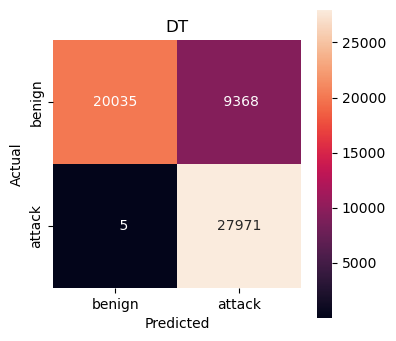

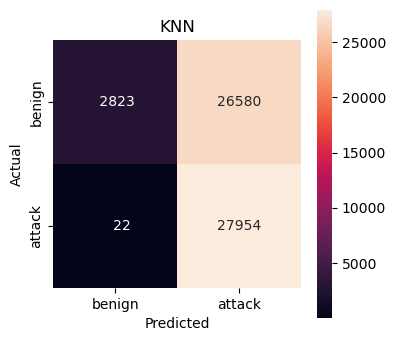

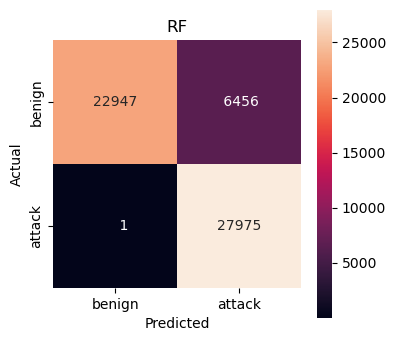

In [13]:
name = []
for name, clf in pipelines:
    model_test = clf.predict(X_data)
    print("Model name: ",name.upper())
    print(classification_report(y_data.values, model_test, digits=4, target_names=['benign','attack']))
    print("\n")
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cm = confusion_matrix(y_data.values, model_test)
    ax = sns.heatmap(cm, annot=True, fmt='5g', square=True, xticklabels=['benign','attack'], yticklabels=['benign','attack'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(name.upper())
    data2[name.upper()] = model_test # add the column to data2 with predicted labels

## Which attack flows have been mis-predicted by de different models

In [14]:
# KNN
data2.flow_id[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['KNN'])].count()

22

In [15]:
data2[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['KNN'])].drop(columns = ['RF', 'DT'])

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label,KNN
14753,10.37.7.254-10.37.26.145-49251-80-6,10.37.7.254,49251,10.37.26.145,80,6,1706873401678948,568,0.0,8.0,0.0,4.0,32.0,5.656854,14084.507042,3521.126761,3521.126761,0.0,2,8,8.0,0.0,4.0,5.656854,20,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,568.0,568.0,568.0,0.0,568,568.0,568.0,568.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0,-1,1,0
14755,10.37.7.254-10.37.26.145-49251-23-6,10.37.7.254,49251,10.37.26.145,23,6,1706873401684213,366,0.0,8.0,0.0,4.0,32.0,5.656854,21857.923497,5464.480874,5464.480874,0.0,2,8,8.0,0.0,4.0,5.656854,20,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,366.0,366.0,366.0,0.0,366,366.0,366.0,366.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0,-1,1,0
14756,10.37.7.254-10.37.26.145-49251-21-6,10.37.7.254,49251,10.37.26.145,21,6,1706873401684216,364,0.0,8.0,0.0,4.0,32.0,5.656854,21978.021978,5494.505495,5494.505495,0.0,2,8,8.0,0.0,4.0,5.656854,20,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,364.0,364.0,364.0,0.0,364,364.0,364.0,364.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0,-1,1,0
101101,10.37.7.254-10.37.26.145-60588-443-6,10.37.7.254,60588,10.37.26.145,443,6,1706868301761873,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.0,0.0,0.0,0.000000,24,24,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1024,-1,1,0
106531,10.37.7.254-10.37.26.145-42776-443-6,10.37.7.254,42776,10.37.26.145,443,6,1706869801333112,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.0,0.0,0.0,0.000000,24,24,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1024,-1,1,0
166678,10.37.7.254-10.37.26.145-48995-443-6,10.37.7.254,48995,10.37.26.145,443,6,1706873401603493,0,0.0,8.0,8.0,8.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,8,8.0,8.0,8.0,0.000000,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0,-1,1,0
166692,10.37.7.254-10.37.26.145-49251-445-6,10.37.7.254,49251,10.37.26.145,445,6,1706873401678875,0,0.0,8.0,8.0,8.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,8,8.0,8.0,8.0,0.000000,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0,-1,1,0
185907,10.37.7.254-10.37.26.145-55708-433-6,10.37.7.254,55708,10.37.26.145,433,6,1706875557137875,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.

In [16]:
# DT
data2.flow_id[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['DT'])].count()

5

In [17]:
data2[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['DT'])].drop(columns = ['RF', 'KNN'])

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label,DT
14752,10.37.7.254-10.37.26.145-49251-5900-6,10.37.7.254,49251,10.37.26.145,5900,6,1706873401678897,617,0.0,8.0,0.0,4.0,32.0,5.656854,12965.964344,3241.491086,3241.491086,0.0,2,8,8.0,0.0,4.0,5.656854,20,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,617.0,617.0,617.0,0.0,617,617.0,617.0,617.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0,-1,1,0
101101,10.37.7.254-10.37.26.145-60588-443-6,10.37.7.254,60588,10.37.26.145,443,6,1706868301761873,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.0,0.0,0.0,0.000000,24,24,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1024,-1,1,0
106531,10.37.7.254-10.37.26.145-42776-443-6,10.37.7.254,42776,10.37.26.145,443,6,1706869801333112,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.0,0.0,0.0,0.000000,24,24,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1024,-1,1,0
166678,10.37.7.254-10.37.26.145-48995-443-6,10.37.7.254,48995,10.37.26.145,443,6,1706873401603493,0,0.0,8.0,8.0,8.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,8,8.0,8.0,8.0,0.000000,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0,-1,1,0
232626,10.37.7.254-10.37.26.145-43125-443-6,10.37.7.254,43125,10.37.26.145,443,6,1706878802460149,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0.0,0.0,0.0,0.000000,24,24,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1024,-1,1,0


In [18]:
# RF
data2.flow_id[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['RF'])].count()

1

In [19]:
data2[(data2['src_addr'] == '10.37.7.254') & (data2['dst_addr'] == '10.37.26.145') & (data2['label'] != data2['RF'])].drop(columns = ['DT', 'KNN'])

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label,RF
14752,10.37.7.254-10.37.26.145-49251-5900-6,10.37.7.254,49251,10.37.26.145,5900,6,1706873401678897,617,0.0,8.0,0.0,4.0,32.0,5.656854,12965.964344,3241.491086,3241.491086,0.0,2,8,8.0,0.0,4.0,5.656854,20,0,1,0,0,0.0,0.0,0.0,0.0,0,0,0,617.0,617.0,617.0,0.0,617,617.0,617.0,617.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,0.0,0.0,0,-1,1,0


# References
>[1] A. Rosay, F. Carlier, E. Cheval, and P. Leroux, “From CIC-IDS2017 to LYCOS-IDS2017: A corrected dataset for better performance,” in IEEE/WIC/ACM International Conference on Web Intelligence, ESSENDON VIC Australia: ACM, Dec. 2021, pp. 570–575. doi: 10.1145/3486622.3493973.\